# Simple Example
With tributary we can easily construct a forward-propagating reactive graph

In [1]:
import tributary.streaming as ts
import random, time

In [2]:
def foo():
    return random.random()

def long():
    print('long called!')
    time.sleep(1)
    return 5


# A timer calls the given function every interval up to count times
test = ts.Timer(foo, {}, interval=.5, count=5)

test2 = ts.Negate(test)

res2 = test + test2

p2 = ts.Print(res2)

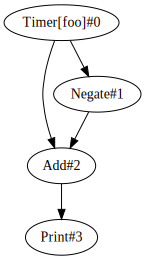

In [3]:
ts.GraphViz(p2)

In [4]:
x = ts.run(p2)

0.0
0.0
0.0
0.0
0.0


In [5]:
x.result()

[0.0, 0.0, 0.0, 0.0, 0.0]

# More Complex Example
Let's construct a slightly more complex graph

In [6]:
import asyncio

def foo():
    return random.random()

async def long():
    await asyncio.sleep(1)
    return 5
    
rand = ts.Timer(foo, interval=0, count=5)
five = ts.Timer(long, interval=0, count=5)
one = ts.Const(1)
five2 = ts.Const(5)
neg_rand = ts.Negate(rand)


x1 = rand + five # 5 + rand
x2 = x1 - five2 # rand
x3 = x2 + neg_rand # 0
res = x3 + one # 1

p = ts.Print(res)


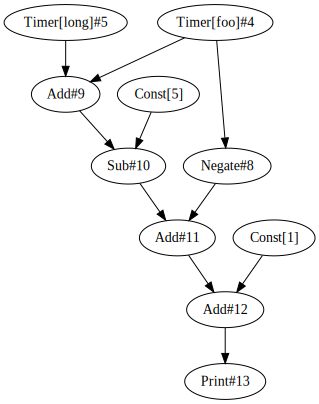

In [7]:
p.graphviz()

In [8]:
x = ts.run(p)

0.9999999999999999
0.9999999999999999
0.9999999999999999
1.0000000000000004
0.9999999999999998


In [9]:
x.result()

[0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 1.0000000000000004,
 0.9999999999999998]

# Rolling Mean

In [10]:
def stream():
    for _ in range(10):
        yield _

f = ts.Foo(stream)
s = f.rollingSum()
c = f.rollingCount()
f3 = ts.Div(s, c)
p = ts.Print(f3)



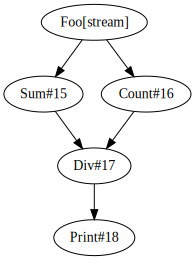

In [11]:
p.graphviz()

In [12]:
x = ts.run(p)

0.0
0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5


In [13]:
x.result()

[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]

# Custom Calculations and Window Functions


In [14]:
def myfoo(ds):
    for d in ds:
        vals = d.values()
        d['HIGH'] = max(vals)
        d['LOW'] = min(vals)
        d['MID'] = sum(vals)/len(vals)
    avgs = [x['MID'] for x in ds]
    ds[-1]['SMA'] = sum(avgs)/len(avgs)
    return [ds[-1]]

In [15]:
vals = ts.Random(100)
w = ts.Window(vals, size=5)
n = ts.Apply(w, myfoo)
psp1 = ts.Perspective(n, schema={'HIGH': float, 'LOW': float, 'MID': float, 'SMA': float}, plugin='y_line')
x = ts.run(ts.Perspective(psp1, schema={'HIGH': float, 'LOW': float, 'MID': float, 'SMA': float}))
# This will only display in the notebook, not on Github
# it uses https://perspective.finos.org/

PerspectiveWidget(columns=['HIGH', 'LOW', 'MID', 'SMA'], plugin='y_line')

PerspectiveWidget(columns=['HIGH', 'LOW', 'MID', 'SMA'])

# Symbolic - Simple Example
Using tributary's sympy functionality, we can construct relatively complicated graphs. Here we will construct as simple lazy graph

In [16]:
import tributary.symbolic as ts
import tributary.streaming as tss

# Parse sympy expression
expr = ts.parse_expression("10sin**2 x**2 + 3xyz + tan theta")

# Generate a new class representing the graph
clz = ts.construct_streaming(expr)


# A function to use as an input
def foo(*args):
    for _ in range(5):
        yield _

# Construct with inputs
x = clz(x=tss.Const(1), y=tss.Foo(foo), z=tss.Timer(lambda: 1, count=0), theta=tss.Const(4))

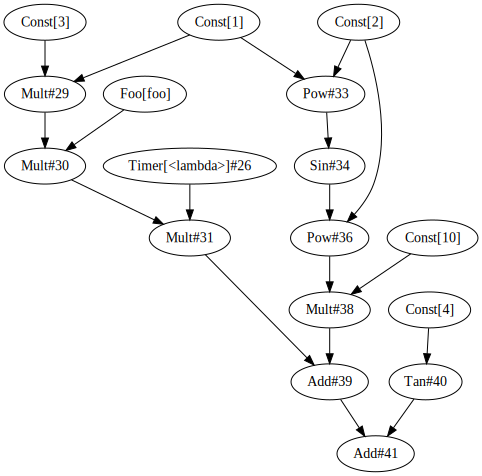

In [17]:
# View the graph
x.graphviz()

In [18]:
# Run the graph
y = x.run()
y

<Task pending coro=<_run() running at /Users/theocean154/Programs/projects/tributary/tributary/examples/tributary/streaming/__init__.py:11>>

In [19]:
y.result()

# Symbolic - More Complicated Example
Here we will construct a streaming pricer for a vanilla european option

In [20]:
import numpy as np
import sympy as sy
from IPython.display import display, HTML
from sympy.stats import Normal as syNormal, cdf
sy.init_printing()

# adapted from https://gist.github.com/raddy/bd0e977dc8437a4f8276
#spot, strike, vol, days till expiry, interest rate, call or put (1,-1)
spot, strike, vol, dte, rate, cp = sy.symbols('spot strike vol dte rate cp')

T = dte / 260.
N = syNormal('N', 0.0, 1.0)

d1 = (sy.ln(spot / strike) + (0.5 * vol ** 2) * T) / (vol * sy.sqrt(T))
d2 = d1 - vol * sy.sqrt(T)

TimeValueExpr = sy.exp(-rate * T) * (cp * spot * cdf(N)(cp * d1) - cp * strike  * cdf(N)(cp * d2))

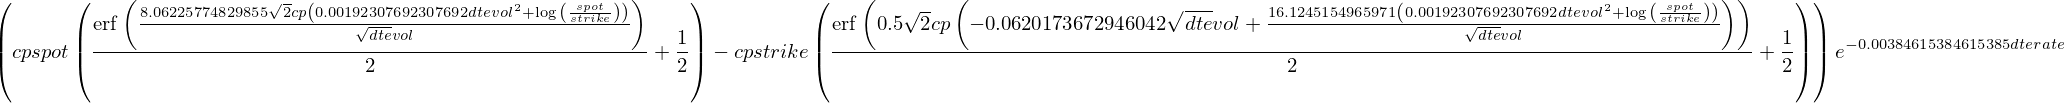

In [21]:
TimeValueExpr

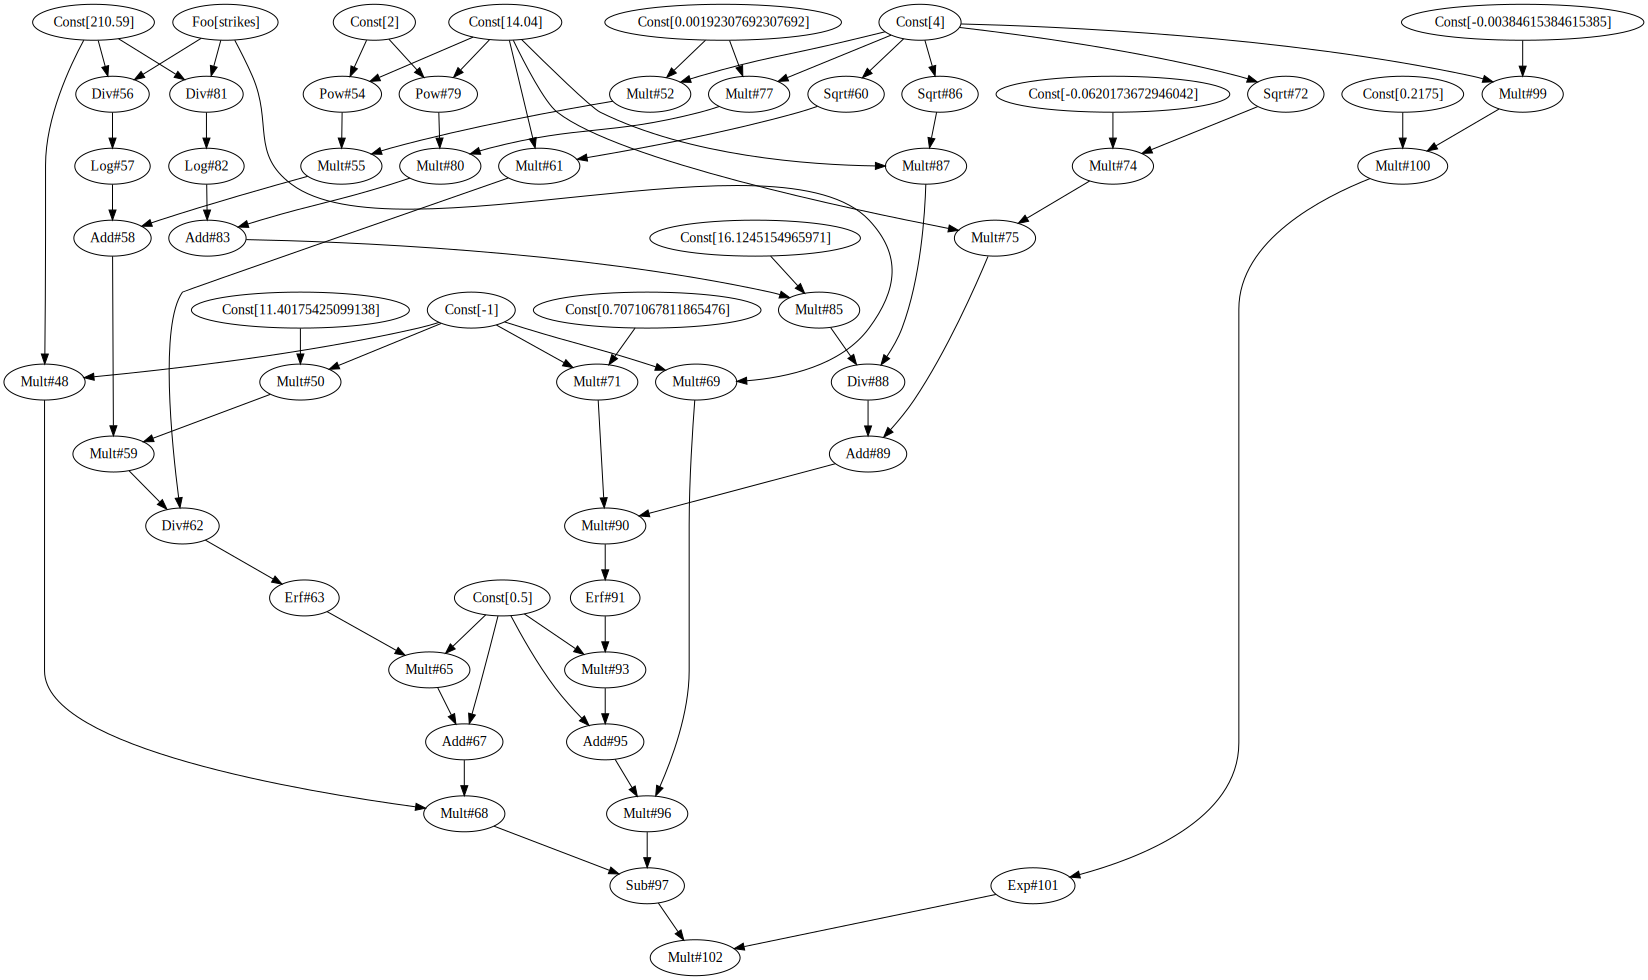

In [22]:
import tributary.symbolic as ts
PriceClass = ts.construct_streaming(TimeValueExpr)


def strikes():
    strike = 205
    while strike < 220:
        yield strike
        strike += 2.5

price = PriceClass(spot=tss.Const(210.59),
                   strike=tss.Foo(strikes),
                   vol=tss.Const(14.04),
                   dte=tss.Const(4),
                   rate=tss.Const(.2175),
                   cp=tss.Const(-1))

price.graphviz()


Our function `strikes` will stream in strike prices, and we will see our price output change accordingly

In [23]:
x = price.run()


In [24]:
x.result()